![alt text](https://drive.google.com/uc?export=view&id=1UXScsVx_Wni_JuDdB8LeTnM6jsPfIwkW)

Proprietary content. © Great Learning. All Rights Reserved. Unauthorized use or distribution prohibited.

# Sentiment Classification

### Dataset
- Dataset of 50,000 movie reviews from IMDB, labeled by sentiment positive (1) or negative (0)
- Reviews have been preprocessed, and each review is encoded as a sequence of word indexes (integers).
- For convenience, words are indexed by overall frequency in the dataset, so that for instance the integer "3" encodes the 3rd most frequent word in the data. This allows for quick filtering operations such as: "only consider the top 10,000 most common words, but eliminate the top 20 most common words".
- As a convention, "0" does not stand for a specific word, but instead is used to encode any unknown word.

Command to import data
- `from tensorflow.keras.datasets import imdb`

### Import the data (4 Marks)
- Use `imdb.load_data()` method
- Get train and test set
- Take 10000 most frequent words

import os
from operator import itemgetter 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from keras import models, regularizers, layers, optimizers, losses, metrics
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils, to_categorical
from keras.datasets import imdb

In [1]:
# Import packages
import pandas as pd, numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
assert tf.__version__ >= '2.0'

from itertools import islice

# Keras
from keras.layers import Dense, Embedding, LSTM, Dropout, MaxPooling1D, Conv1D
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.preprocessing import sequence
from keras.datasets import imdb

from keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Suppress warnings
import warnings; warnings.filterwarnings('ignore')

random_state = 42
np.random.seed(random_state)
tf.random.set_seed(random_state)

Using TensorFlow backend.


### Pad each sentence to be of same length (4 Marks)
- Take maximum sequence length as 300

In [2]:
vocab_size = 10000
maxlen = 300
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words = vocab_size)

x_train = pad_sequences(x_train, maxlen = maxlen, padding = 'pre')
x_test =  pad_sequences(x_test, maxlen = maxlen, padding = 'pre')

X = np.concatenate((x_train, x_test), axis = 0)
y = np.concatenate((y_train, y_test), axis = 0)



x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = random_state, shuffle = True)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size = 0.2, random_state = random_state, shuffle = True)

print('---'*20, f'\nNumber of rows in training dataset: {x_train.shape[0]}')
print(f'Number of columns in training dataset: {x_train.shape[1]}')
print(f'Number of unique words in training dataset: {len(np.unique(np.hstack(x_train)))}')


print('---'*20, f'\nNumber of rows in validation dataset: {x_valid.shape[0]}')
print(f'Number of columns in validation dataset: {x_valid.shape[1]}')
print(f'Number of unique words in validation dataset: {len(np.unique(np.hstack(x_valid)))}')


print('---'*20, f'\nNumber of rows in test dataset: {x_test.shape[0]}')
print(f'Number of columns in test dataset: {x_test.shape[1]}')
print(f'Number of unique words in test dataset: {len(np.unique(np.hstack(x_test)))}')


print('---'*20, f'\nUnique Categories: {np.unique(y_train), np.unique(y_valid), np.unique(y_test)}')

------------------------------------------------------------ 
Number of rows in training dataset: 32000
Number of columns in training dataset: 300
Number of unique words in training dataset: 9999
------------------------------------------------------------ 
Number of rows in validation dataset: 8000
Number of columns in validation dataset: 300
Number of unique words in validation dataset: 9984
------------------------------------------------------------ 
Number of rows in test dataset: 10000
Number of columns in test dataset: 300
Number of unique words in test dataset: 9995
------------------------------------------------------------ 
Unique Categories: (array([0, 1], dtype=int64), array([0, 1], dtype=int64), array([0, 1], dtype=int64))


In [3]:
for i in range(0,3):
    print (len(x_train[i]))

300
300
300


In [4]:
x_train

array([[   0,    0,    0, ...,    2,   18,  113],
       [   0,    0,    0, ...,   39, 1889,    2],
       [   0,    0,    0, ...,  433,   10,   10],
       ...,
       [   0,    0,    0, ...,   46,    7,   72],
       [ 374,  500,    2, ..., 3492, 4294,  830],
       [3063,   14, 1187, ...,   64,    6,  506]])

### Print shape of features & labels (4 Marks)

In [5]:
x_train.shape

(32000, 300)

In [6]:
x_test.shape

(10000, 300)

In [7]:
data=pd.DataFrame.from_records(x_train)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0,0,0,0,0,0,0,0,0,0,...,33,222,13,124,13,28,77,2,18,113
1,0,0,0,0,0,0,0,0,0,0,...,3088,11,63,36,2,68,555,39,1889,2
2,0,0,0,0,0,0,0,0,0,0,...,46,1501,5,271,39,78,8,433,10,10
3,0,0,0,0,0,0,0,0,0,0,...,244,1018,252,15,3633,36,80,2,15,99
4,0,0,0,0,0,0,0,0,0,0,...,4752,908,310,8,202,178,6,2,786,2492


Number of review, number of words in each review

In [8]:
data.describe()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
count,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,...,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000
mean,172.157281,175.706562,179.174625,181.260844,180.998781,179.397469,180.618250,183.153781,181.302312,191.734531,...,644.957750,633.282250,622.849625,636.573281,633.476344,634.363781,631.616844,576.730531,645.384688,1046.984875
std,851.409513,861.322390,884.413498,864.840651,890.567717,868.222766,879.500435,887.351445,869.003919,904.680674,...,1504.123808,1477.307788,1450.853459,1473.621678,1473.942470,1468.729612,1461.547991,1373.699426,1464.213046,1819.475102
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,11.000000,10.000000,46.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,62.000000,61.000000,62.000000,62.000000,65.000000,65.000000,65.000000,54.000000,68.000000,250.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,422.000000,410.000000,412.000000,432.000000,422.250000,435.250000,437.000000,387.000000,470.000000,1109.000000
max,9941.000000,9995.000000,9992.000000,9945.000000,9996.000000,9980.000000,9996.000000,9990.000000,9901.000000,9989.000000,...,9988.000000,9996.000000,9994.000000,9986.000000,9996.000000,9998.000000,9997.000000,9997.000000,9984.000000,9990.000000


In [9]:
# summarize size
print("Training data: ")
print(X.shape)
print(y.shape)

Training data: 
(50000, 300)
(50000,)


In [10]:
# Summarize number of classes
print("Classes: ")
print(np.unique(y))

Classes: 
[0 1]


In [11]:
# Summarize number of words
print("Number of words: ")
print(len(np.unique(np.hstack(X))))

Number of words: 
9999


Review length: 
Mean 300.00 words (0.000000)


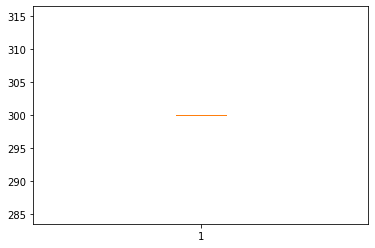

In [12]:
# Summarize review length
print("Review length: ")
result = [len(x) for x in X]
print("Mean %.2f words (%f)" % (np.mean(result), np.std(result)))
# plot review length
plt.boxplot(result)
plt.show()

Number of labels

In [13]:
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(
num_words=10000)

In [14]:
print("train_labels ", train_labels.shape)
print("test_labels ", test_labels.shape)

train_labels  (25000,)
test_labels  (25000,)


### Print value of any one feature and it's label (4 Marks)

Feature value

In [15]:
train_labels.shape

(25000,)

Label value

In [16]:
train_labels[200]

1

### Decode the feature value to get original sentence (4 Marks)

First, retrieve a dictionary that contains mapping of words to their index in the IMDB dataset

In [17]:
def decode_review(x, y):
  w2i = imdb.get_word_index()                                
  w2i = {k:(v + 3) for k, v in w2i.items()}
  w2i['<PAD>'] = 0
  w2i['<START>'] = 1
  w2i['<UNK>'] = 2
  i2w = {i: w for w, i in w2i.items()}

  ws = (' '.join(i2w[i] for i in x))
  print(f'Review: {ws}')
  print(f'Actual Sentiment: {y}')
  return w2i, i2w


Now use the dictionary to get the original words from the encodings, for a particular sentence

In [18]:
w2i, i2w = decode_review(x_train[200], y_train[200])
# get first 50 key, value pairs from id to word dictionary
print('---'*30, '\n', list(islice(i2w.items(), 0, 50)))

Review: <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

Get the sentiment for the above sentence
- positive (1)
- negative (0)

In [19]:
print(f'Actual Sentiment: {y}')

Actual Sentiment: [1 0 0 ... 0 0 0]


### Define model (10 Marks)
- Define a Sequential Model
- Add Embedding layer
  - Embedding layer turns positive integers into dense vectors of fixed size
  - `tensorflow.keras` embedding layer doesn't require us to onehot encode our words, instead we have to give each word a unique integer number as an id. For the imdb dataset we've loaded this has already been done, but if this wasn't the case we could use sklearn LabelEncoder.
  - Size of the vocabulary will be 10000
  - Give dimension of the dense embedding as 100
  - Length of input sequences should be 300
- Add LSTM layer
  - Pass value in `return_sequences` as True
- Add a `TimeDistributed` layer with 100 Dense neurons
- Add Flatten layer
- Add Dense layer

In [20]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models

In [21]:
#Define a sequential model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Embedding, LSTM, Dropout
print('Build model...')
model = Sequential()

Build model...


In [22]:
# Embedding layer
voca_size = 10000
dimen=100
leng=300
model.add(Embedding(voca_size, dimen,input_length=leng))

In [23]:
for layer in model.layers:
    print(layer.output_shape)

(None, 300, 100)


In [24]:
# LSTM layer
model.add(LSTM(64, dropout=0.2,return_sequences=True))

In [25]:
# Flatten layer
model.add(Flatten())

In [26]:
# Dense layer
model.add(Dense(1, activation='sigmoid'))

### Compile the model (4 Marks)
- Use Optimizer as Adam
- Use Binary Crossentropy as loss
- Use Accuracy as metrics

In [27]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Print model summary (4 Marks)

In [28]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 100)          1000000   
_________________________________________________________________
lstm (LSTM)                  (None, 300, 64)           42240     
_________________________________________________________________
flatten (Flatten)            (None, 19200)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 19201     
Total params: 1,061,441
Trainable params: 1,061,441
Non-trainable params: 0
_________________________________________________________________
None


In [29]:
# Adding callbacks
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 0)  
mc = ModelCheckpoint('imdb_model.h5', monitor = 'val_loss', mode = 'min', save_best_only = True, verbose = 1)

### Fit the model (4 Marks)

In [30]:
x_train.shape

(32000, 300)

In [31]:
y_train.shape

(32000,)

In [32]:
NumEpochs = 3
BatchSize = 64
history = model.fit(x_train, y_train, validation_data = (x_valid, y_valid), epochs = 3, batch_size = 64, verbose = True)

Epoch 1/3
500/500 [==============================] - 147s 295ms/step - loss: 0.3475 - accuracy: 0.8408 - val_loss: 0.2733 - val_accuracy: 0.8846
Epoch 2/3
500/500 [==============================] - 145s 289ms/step - loss: 0.1997 - accuracy: 0.9214 - val_loss: 0.2595 - val_accuracy: 0.8944
Epoch 3/3
500/500 [==============================] - 150s 301ms/step - loss: 0.1302 - accuracy: 0.9519 - val_loss: 0.2902 - val_accuracy: 0.8880


### Evaluate model (4 Marks)

In [33]:
# Evaluate the model
scores = model.evaluate(x_test, y_test, batch_size = 64)
print('Test accuracy: %.2f%%' % (scores[1]*100))

157/157 [==============================] - 13s 82ms/step - loss: 0.2863 - accuracy: 0.8920
Test accuracy: 89.20%


### Predict on one sample (4 Marks)

In [34]:
y_pred = model.predict_classes(x_test)
print(f'Classification Report:\n{classification_report(y_pred, y_test)}')

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      5022
           1       0.88      0.90      0.89      4978

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [35]:
decode_review(x_test[10], y_test[10])
print(f'Predicted sentiment: {y_pred[10][0]}')

Review: <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P

## Conclusion
### Sentiment classification task on the IMDB dataset, on test dataset,
#### * Accuracy: > 88%
#### * F1-score: = 89%
#### * Loss of 0.28